In [4]:
# Core MDAnalysis imports
from imdclient.IMDREADER import IMDReader
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
from MDAnalysis.analysis.rms import RMSF
from imdclient.tests.datafiles import NAMD_TOPOL
import matplotlib.pyplot as plt
import numpy as np
import concurrent.futures
import logging

KeyError: 'rdf'

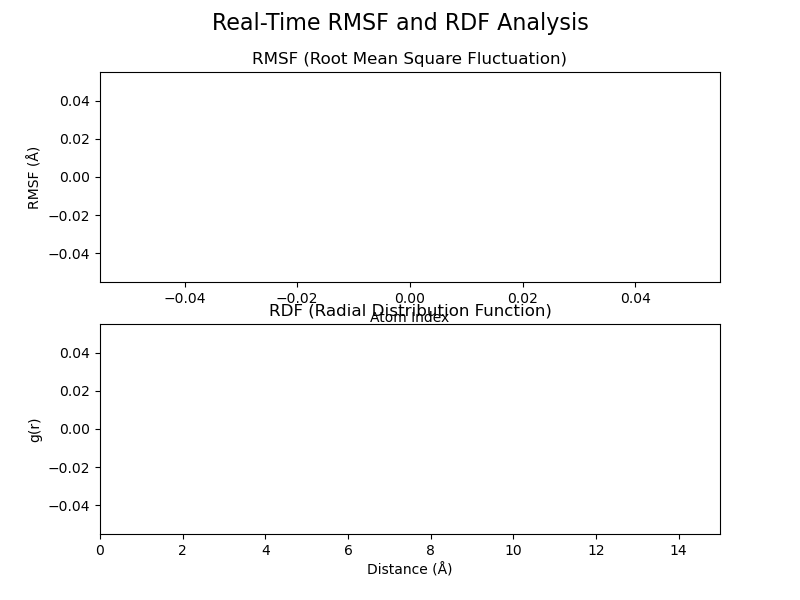

In [ ]:
# Enable widget for interactive plotting in Jupyter
%matplotlib widget

# Set up logging
logger = logging.getLogger("imdclient.IMDClient")
file_handler = logging.FileHandler("imdreader.log")
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)
logger.setLevel(logging.INFO)

# Initialize Universe with IMD server connection
u = mda.Universe(NAMD_TOPOL, "imd://localhost:1025")

g = u.atoms  # Select all atoms

# Set up RMSF and RDF analyses
rdf = InterRDF(g, g)
rdf._ts = u.trajectory.ts  # Set trajectory for RDF
rmsf = RMSF(g)
rmsf._ts = u.trajectory.ts  # Set trajectory for RMSF
rdf._prepare()  # Prepare RDF analysis
rmsf._prepare()  # Prepare RMSF analysis

# Set up live plots with two subplots for RMSF and RDF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
fig.suptitle("Real-Time RMSF and RDF Analysis", fontsize=16)

# Initialize RMSF plot
rmsf_line, = ax1.plot([], [], color="blue")
ax1.set_title("RMSF (Root Mean Square Fluctuation)")
ax1.set_xlabel("Atom Index")
ax1.set_ylabel("RMSF (Å)")

# Initialize RDF plot
rdf_line, = ax2.plot([], [], color="orange")
ax2.set_title("RDF (Radial Distribution Function)")
ax2.set_xlabel("Distance (Å)")
ax2.set_ylabel("g(r)")
ax2.set_xlim(0, 15)  # Set RDF x-range

# Function to update the RMSF plot dynamically
def update_rmsf_plot(rmsf_values):
    x_data = np.arange(len(rmsf_values))
    rmsf_line.set_xdata(x_data)
    rmsf_line.set_ydata(rmsf_values)
    ax1.set_ylim(0, max(rmsf_values) + 0.5)  # Adjust Y-limits dynamically
    fig.canvas.draw_idle()
    plt.pause(0.001)  # Allow for the plot to update in Jupyter

# Function to update the RDF plot dynamically
def update_rdf_plot(rdf_values):
    rdf_line.set_xdata(rdf.bins)
    rdf_line.set_ydata(rdf_values)
    ax2.set_ylim(0, max(rdf_values) + 0.5)  # Adjust Y-limits dynamically
    fig.canvas.draw_idle()
    plt.pause(0.001)  # Allow for the plot to update in Jupyter

# Concurrent execution of RMSF and RDF calculations
def run_analysis():
    count = 0
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for ts in u.trajectory:
            # Submit RMSF and RDF frame calculations to the executor
            rdf_frame = executor.submit(rdf._single_frame)
            rmsf._frame_index = count
            rmsf_frame = executor.submit(rmsf._single_frame)
            
            # Wait for both threads to finish
            rdf_frame.result()
            rmsf_frame.result()

            # Update plots every 10 frames
            if count % 10 == 0:
                update_rdf_plot(rdf.rdf)  # Live update of RDF plot
                update_rmsf_plot(rmsf.results["rmsf"])  # Live update of RMSF plot

            count += 1

    # Finalize RDF and RMSF calculations
    rdf.n_frames = count
    rdf._conclude()
    rmsf._conclude()

    # Final plot updates
    update_rdf_plot(rdf.results["rdf"])
    update_rmsf_plot(rmsf.results["rmsf"])

    logger.info("Completed synchronized RMSF and RDF calculation and plotting.")

# Start the analysis and plotting
run_analysis()
